# Batch Processing and Dimensionality Reduction on Gaia DR3 (High pm)
This notebook processes the Gaia DR3 subset of stars with high proper motion (pm > 50).

In [1]:
import pacmap
import time
import trimap
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from astroquery.gaia import Gaia
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings

### Batch Processing Configuration

In [2]:
BATCH_SIZE = 20000  # Number of stars per batch (adjust as needed)
MAX_STARS_TO_PROCESS = 500_000  # Safety limit for demonstration; increase/remove for full run

TEST_MODE = False  # Set to False to process the full dataset based on MAX_STARS_TO_PROCESS
MAX_BATCHES_IN_TEST_MODE = 1  # Number of batches to process if TEST_MODE is True

features_for_dr = [
    'parallax', 'pmra', 'pmdec', 'pm',
    'phot_g_mean_mag', 'bp_rp_color',
    'radial_velocity'
]

features_to_color_tuples = [
    ('phot_g_mean_mag', 'G-band Magnitude', 'viridis_r'),
    ('bp_rp_color', 'BP-RP Color Index', 'cividis'),
    ('phot_bp_mean_mag', 'BP Magnitude', 'viridis_r'),
    ('phot_rp_mean_mag', 'RP Magnitude', 'plasma'),
]

plotting_feature_names_to_save = list(set([f[0] for f in features_to_color_tuples] + ['source_id']))
output_hdf_file = '../data/gaia_high_pm.h5'

scaler = StandardScaler()

all_plotting_data_batches = []
all_scaled_features_batches = []
is_first_batch_scaling = True
total_stars_processed = 0

### Batch Data Fetching, Preprocessing, and Incremental PCA Fitting

In [3]:
def fetch_gaia_data(batch_size=20000, last_source_id=None):
    where_clause = "g.pm > 100"
    if last_source_id is not None:
        where_clause += f" AND g.source_id > {last_source_id}"
    query = f"""
    SELECT TOP {batch_size}
    g.source_id, g.ra, g.dec, g.parallax, g.parallax_error, 
    g.pmra, g.pmra_error, g.pmdec, g.pmdec_error, g.pm,
    g.phot_g_mean_mag, g.phot_bp_mean_mag, g.phot_rp_mean_mag,
    g.radial_velocity, g.radial_velocity_error,
    g.ruwe
    FROM gaiadr3.gaia_source AS g
    WHERE {where_clause}
    ORDER BY g.source_id
    """
    try:
        job = Gaia.launch_job_async(query=query, verbose=False)
        results_table = job.get_results()
        df = results_table.to_pandas()
        return df
    except Exception as e:
        print(f"Error fetching Gaia data (last_source_id {last_source_id}): {e}. Returning empty DataFrame.")
        return pd.DataFrame()

In [ ]:
MAX_CONSECUTIVE_EMPTY_BATCHES = 5  # Allow up to 5 consecutive empty/error batches before stopping
EMPTY_BATCH_SLEEP_SEC = 5 # Wait 5 seconds before retrying after an empty/error batch

warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
current_offset = 0
batches_processed_count = 0
consecutive_empty_batches = 0
last_source_id = None

while total_stars_processed < MAX_STARS_TO_PROCESS:
    if TEST_MODE and batches_processed_count >= MAX_BATCHES_IN_TEST_MODE:
        print(f"TEST_MODE: Reached max batches ({MAX_BATCHES_IN_TEST_MODE}). Stopping.")
        break

    df_batch = fetch_gaia_data(batch_size=BATCH_SIZE, last_source_id=last_source_id)
    if df_batch.empty:
        consecutive_empty_batches += 1
        print(f"Warning: Received empty batch at offset {current_offset} (consecutive empty: {consecutive_empty_batches}). Retrying after {EMPTY_BATCH_SLEEP_SEC}s...")
        if consecutive_empty_batches >= MAX_CONSECUTIVE_EMPTY_BATCHES:
            print(f"Stopping: Reached {MAX_CONSECUTIVE_EMPTY_BATCHES} consecutive empty/error batches.")
            break
        time.sleep(EMPTY_BATCH_SLEEP_SEC)
        continue
    else:
        consecutive_empty_batches = 0  # Reset on successful batch
    
    last_source_id = df_batch['source_id'].max()

    df_batch['bp_rp_color'] = df_batch['phot_bp_mean_mag'] - df_batch['phot_rp_mean_mag']
    batch_features_df = df_batch[features_for_dr].copy()

    for col in batch_features_df.columns:
        if batch_features_df[col].isnull().any():
            batch_features_df[col] = batch_features_df[col].fillna(batch_features_df[col].mean())

    if batch_features_df.isnull().all().any():
        current_offset += len(df_batch)
        total_stars_processed += len(df_batch)
        for pcol in plotting_feature_names_to_save:
            if pcol not in df_batch.columns:
                df_batch[pcol] = np.nan
        all_plotting_data_batches.append(df_batch[plotting_feature_names_to_save].copy())
        continue

    if is_first_batch_scaling:
        scaled_batch_features = scaler.fit_transform(batch_features_df)
        is_first_batch_scaling = False
    else:
        scaled_batch_features = scaler.transform(batch_features_df)

    all_scaled_features_batches.append(scaled_batch_features)

    for pcol in plotting_feature_names_to_save:
        if pcol not in df_batch.columns:
            df_batch[pcol] = np.nan

    all_plotting_data_batches.append(df_batch[plotting_feature_names_to_save].copy())
    processed_in_batch = len(df_batch)
    total_stars_processed += processed_in_batch
    current_offset += processed_in_batch
    batches_processed_count += 1  # Increment batch counter

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


### Aggregate Data, Finalize PCA, Run Other DR Methods, and Save Results

In [5]:
full_plotting_df = pd.DataFrame()
pca_embeddings_final = np.array([])
embeddings = {}

if all_plotting_data_batches:
    full_plotting_df = pd.concat(all_plotting_data_batches).reset_index(drop=True)

    if all_scaled_features_batches:
        full_scaled_features = np.concatenate(all_scaled_features_batches, axis=0)
        tsne_perplexity = min(30.0, max(1.0, full_scaled_features.shape[0] - 2.0))

        if full_scaled_features.shape[0] > 1:
            try:
                embeddings['PCA'] = PCA(n_components=2).fit_transform(full_scaled_features)
            except Exception as e:
                print(f"PCA error: {e}")
            try:
                embeddings['tSNE'] = TSNE(n_components=2, perplexity=tsne_perplexity, n_jobs=8).fit_transform(full_scaled_features)
            except Exception as e:
                print(f"t-SNE error: {e}")
            try:
                embeddings['UMAP'] = umap.UMAP(n_components=2).fit_transform(full_scaled_features)
            except Exception as e:
                print(f"UMAP error: {e}")
            try:
                embeddings['PaCMAP'] = pacmap.PaCMAP(n_components=2).fit_transform(full_scaled_features)
            except Exception as e:
                print(f"PaCMAP error: {e}")
            try:
                embeddings['TriMap'] = trimap.TRIMAP(n_dims=2).fit_transform(full_scaled_features)
            except Exception as e:
                print(f"TriMap error: {e}")

        # Save to HDF5
        try:
            with pd.HDFStore(output_hdf_file, 'w') as store:
                store.put('plotting_data', full_plotting_df, format='table', data_columns=True)
                for dr_name, emb_data in embeddings.items():
                    if emb_data.shape[0] > 0:
                        store.put(f'{dr_name.lower()}_embeddings', pd.DataFrame(emb_data, columns=[f'{dr_name}1', f'{dr_name}2']))
        except Exception as e:
            print(f"Error saving to HDF5: {e}")

C:\Users\looxx\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [6]:
full_scaled_features.shape

(500000, 7)

### Visualize PCA, t-SNE, PaCMAP and TRIMAP

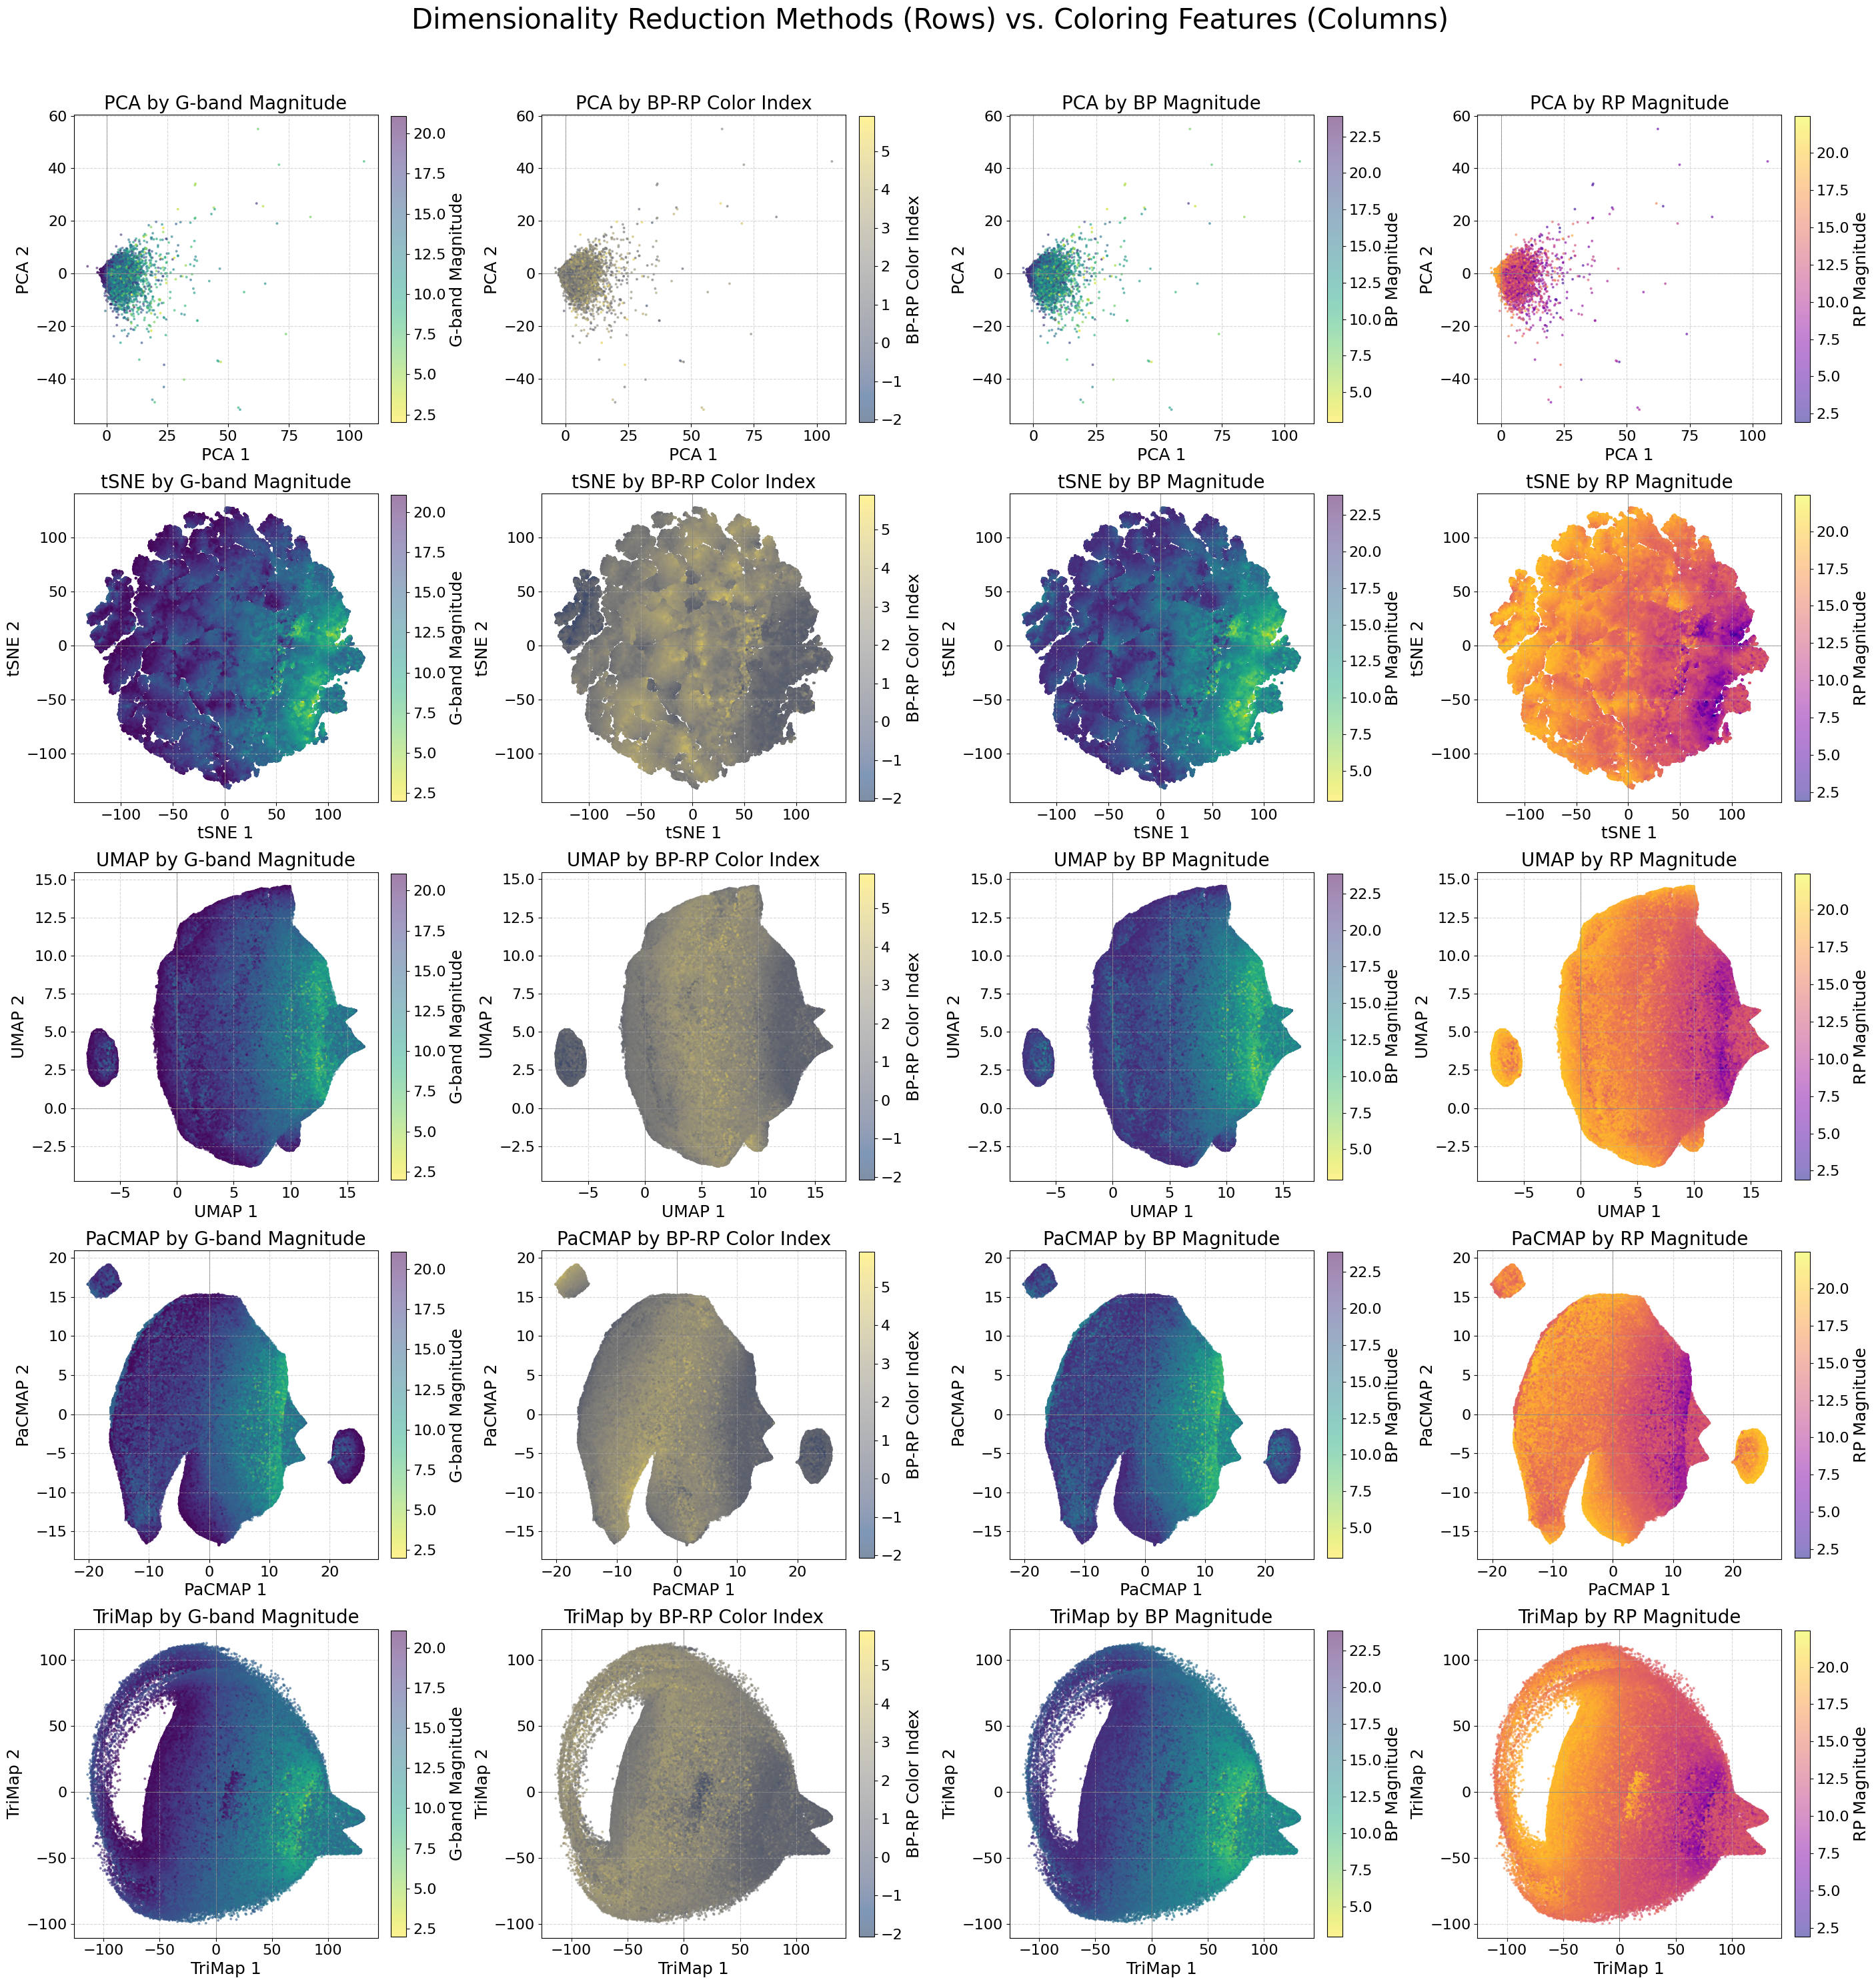

In [7]:
if embeddings and not full_plotting_df.empty:
    n_methods = len(embeddings)
    n_features_to_plot = len(features_to_color_tuples)
    num_points = embeddings[list(embeddings.keys())[0]].shape[0] if embeddings else 0
    marker_size = max(1, 20 / np.log10(max(10, num_points))) if num_points > 0 else 5
    fig, axes = plt.subplots(n_methods, n_features_to_plot, figsize=(7*n_features_to_plot, 6*n_methods), squeeze=False)
    
    title_fontsize = 20
    label_fontsize = 18
    suptitle_fontsize = 30

    for row_idx, (method_name, emb_data) in enumerate(embeddings.items()):
        for col_idx, (feature_name, feature_label, cmap) in enumerate(features_to_color_tuples):
            ax = axes[row_idx][col_idx]
            if feature_name not in full_plotting_df.columns:
                ax.set_title(f'{method_name} - Missing: {feature_label}', fontsize=title_fontsize)
                ax.text(0.5, 0.5, f'Missing:\n{feature_label}', ha='center', va='center', transform=ax.transAxes, fontsize=label_fontsize)
                continue
            
            color_values = full_plotting_df[feature_name]
            current_emb_data = emb_data
            current_color_values = color_values

            if len(emb_data) != len(color_values):
                min_len = min(len(emb_data), len(color_values))
                current_emb_data = emb_data[:min_len]
                current_color_values = color_values[:min_len]
                if min_len == 0:
                    ax.set_title(f'{method_name} by {feature_label} (No data)', fontsize=title_fontsize)
                    continue
            
            if current_color_values.isnull().all():
                scatter = ax.scatter(current_emb_data[:, 0], current_emb_data[:, 1], alpha=0.5, s=marker_size, color='grey')
            else:
                scatter = ax.scatter(current_emb_data[:, 0], current_emb_data[:, 1], c=current_color_values, cmap=cmap, alpha=0.5, s=marker_size)
            
            ax.set_xlabel(f'{method_name} 1', fontsize=label_fontsize)
            ax.set_ylabel(f'{method_name} 2', fontsize=label_fontsize)
            ax.set_title(f'{method_name} by {feature_label}', fontsize=title_fontsize)
            
            try:
                cbar = fig.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
                cbar.set_label(feature_label, fontsize=label_fontsize)
                cbar.ax.tick_params(labelsize=label_fontsize-2) # Adjust colorbar tick label size
            except Exception as e:
                print(f"Could not create colorbar for {method_name} by {feature_label}: {e}")
            
            ax.grid(True, linestyle='--', alpha=0.5)
            ax.axhline(0, color='grey', lw=0.5)
            ax.axvline(0, color='grey', lw=0.5)
            ax.tick_params(axis='both', which='major', labelsize=label_fontsize-2) # Adjust axis tick label size

    plt.suptitle('Dimensionality Reduction Methods (Rows) vs. Coloring Features (Columns)', fontsize=suptitle_fontsize, y=0.99)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

C:\Users\looxx\AppData\Local\Temp\ipykernel_2952\1130380443.py:53: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 1.5, 1, 1.08])


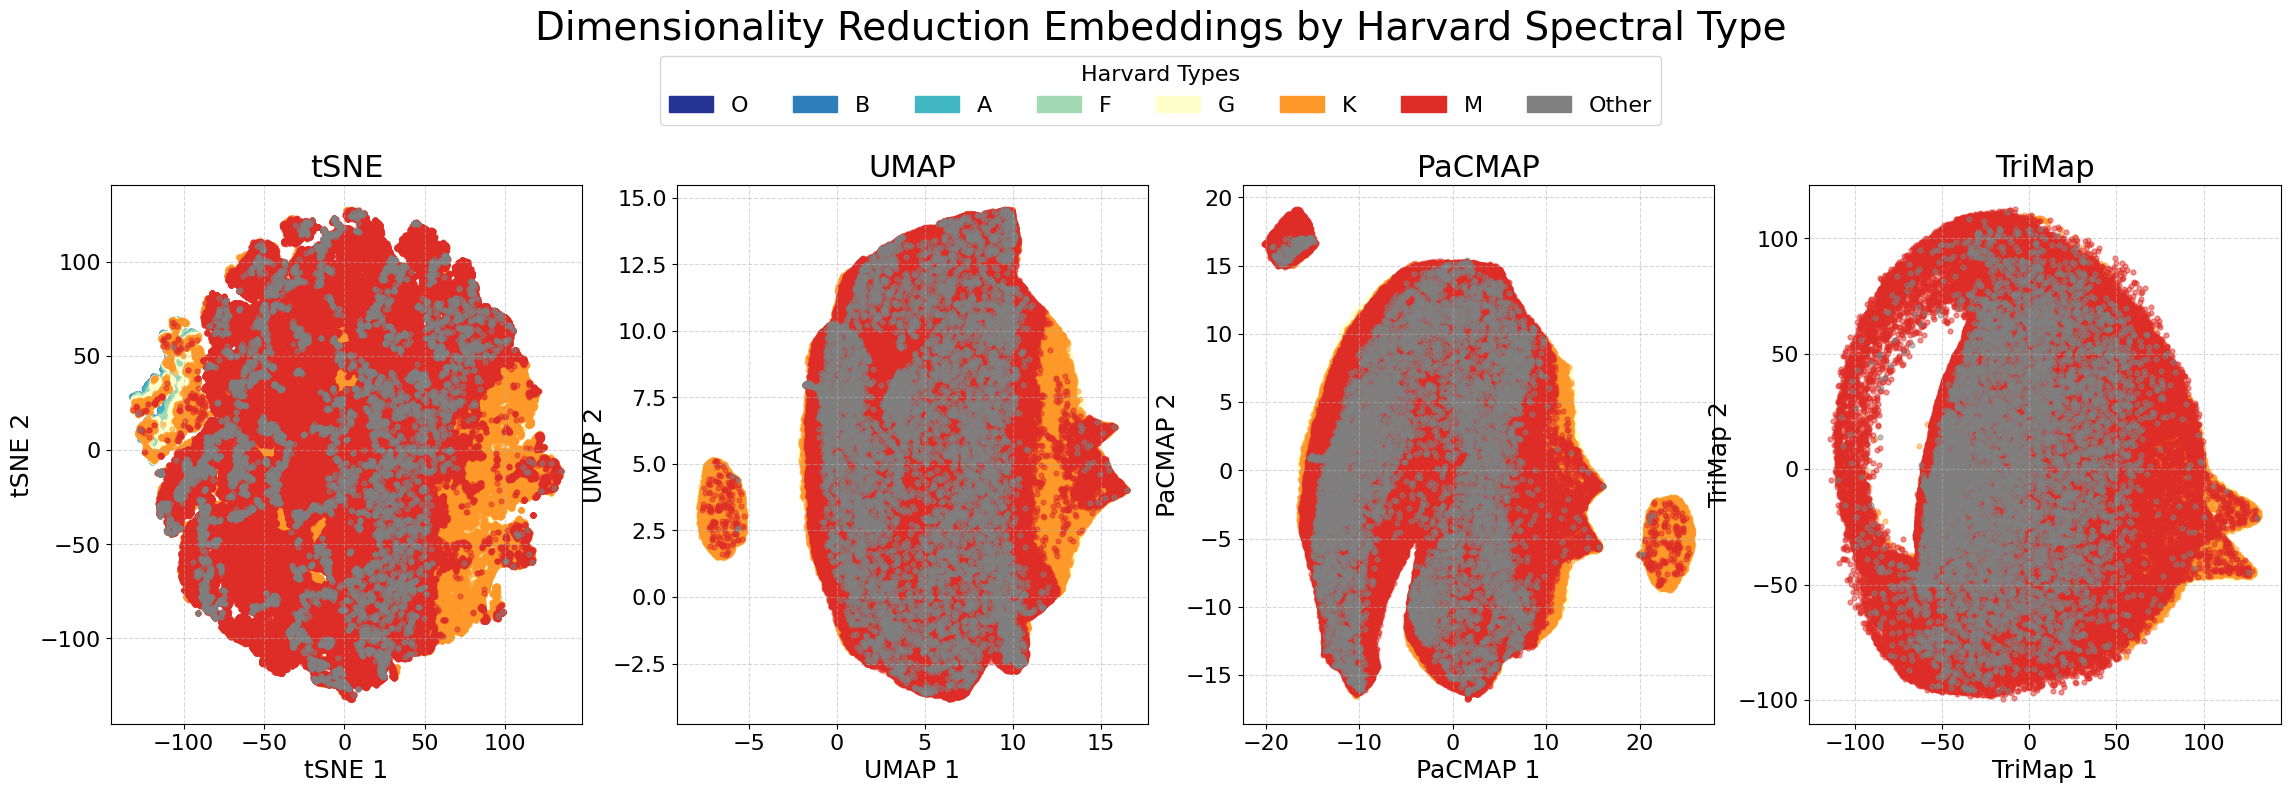

In [ ]:
# Harvard Spectral Type Masking
harvard_types = [
    ('O', (full_plotting_df['bp_rp_color'] < -0.2)),
    ('B', (full_plotting_df['bp_rp_color'] >= -0.2) & (full_plotting_df['bp_rp_color'] < 0.0)),
    ('A', (full_plotting_df['bp_rp_color'] >= 0.0) & (full_plotting_df['bp_rp_color'] < 0.3)),
    ('F', (full_plotting_df['bp_rp_color'] >= 0.3) & (full_plotting_df['bp_rp_color'] < 0.6)),
    ('G', (full_plotting_df['bp_rp_color'] >= 0.6) & (full_plotting_df['bp_rp_color'] < 1.0)),
    ('K', (full_plotting_df['bp_rp_color'] >= 1.0) & (full_plotting_df['bp_rp_color'] < 1.6)),
    ('M', (full_plotting_df['bp_rp_color'] >= 1.6)),
]

harvard_labels = np.full(len(full_plotting_df), 'Other', dtype=object)

for htype, mask in harvard_types:
    harvard_labels[mask] = htype

harvard_colors = {
    'O': '#253494',  # deep blue
    'B': '#2c7fb8',  # blue
    'A': '#41b6c4',  # cyan
    'F': '#a1dab4',  # light green
    'G': '#ffffcc',  # yellow
    'K': '#fe9929',  # orange
    'M': '#de2d26',  # red
    'Other': 'grey'
}

title_fontsize = 22
label_fontsize = 18
legend_fontsize = 16
suptitle_fontsize = 28

# Plot DR embeddings by Harvard type
n_methods = len(dr_methods)
fig, axes = plt.subplots(1, n_methods, figsize=(7*n_methods, 7), squeeze=False)

for idx, method_name in enumerate(dr_methods):
    ax = axes[0][idx]
    emb_data = embeddings[method_name]

    for htype, color in harvard_colors.items():
        mask = (harvard_labels == htype)
        if np.any(mask):
            ax.scatter(
                emb_data[mask, 0], emb_data[mask, 1],
                s=12, alpha=0.5, label=htype, color=color
            )

    ax.set_xlabel(f'{method_name} 1', fontsize=label_fontsize)
    ax.set_ylabel(f'{method_name} 2', fontsize=label_fontsize)
    ax.set_title(f'{method_name}', fontsize=title_fontsize)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(axis='both', which='major', labelsize=label_fontsize-2)

# Single legend
handles = [mpatches.Patch(color=color, label=htype) for htype, color in harvard_colors.items()]
fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=8, fontsize=legend_fontsize, title="Harvard Types", title_fontsize=legend_fontsize)

plt.suptitle('Dimensionality Reduction Embeddings by Harvard Spectral Type', fontsize=suptitle_fontsize, y=1.13)
plt.tight_layout(rect=[0, 1.5, 1, 1.08])
plt.show()

C:\Users\looxx\AppData\Local\Temp\ipykernel_2952\4260652115.py:10: RankWarning: Polyfit may be poorly conditioned
  poly_coeffs = np.polyfit(bp_rp_valid, gmag_valid, 2)
C:\Users\looxx\AppData\Local\Temp\ipykernel_2952\4260652115.py:43: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 1.5, 1, 1.08])


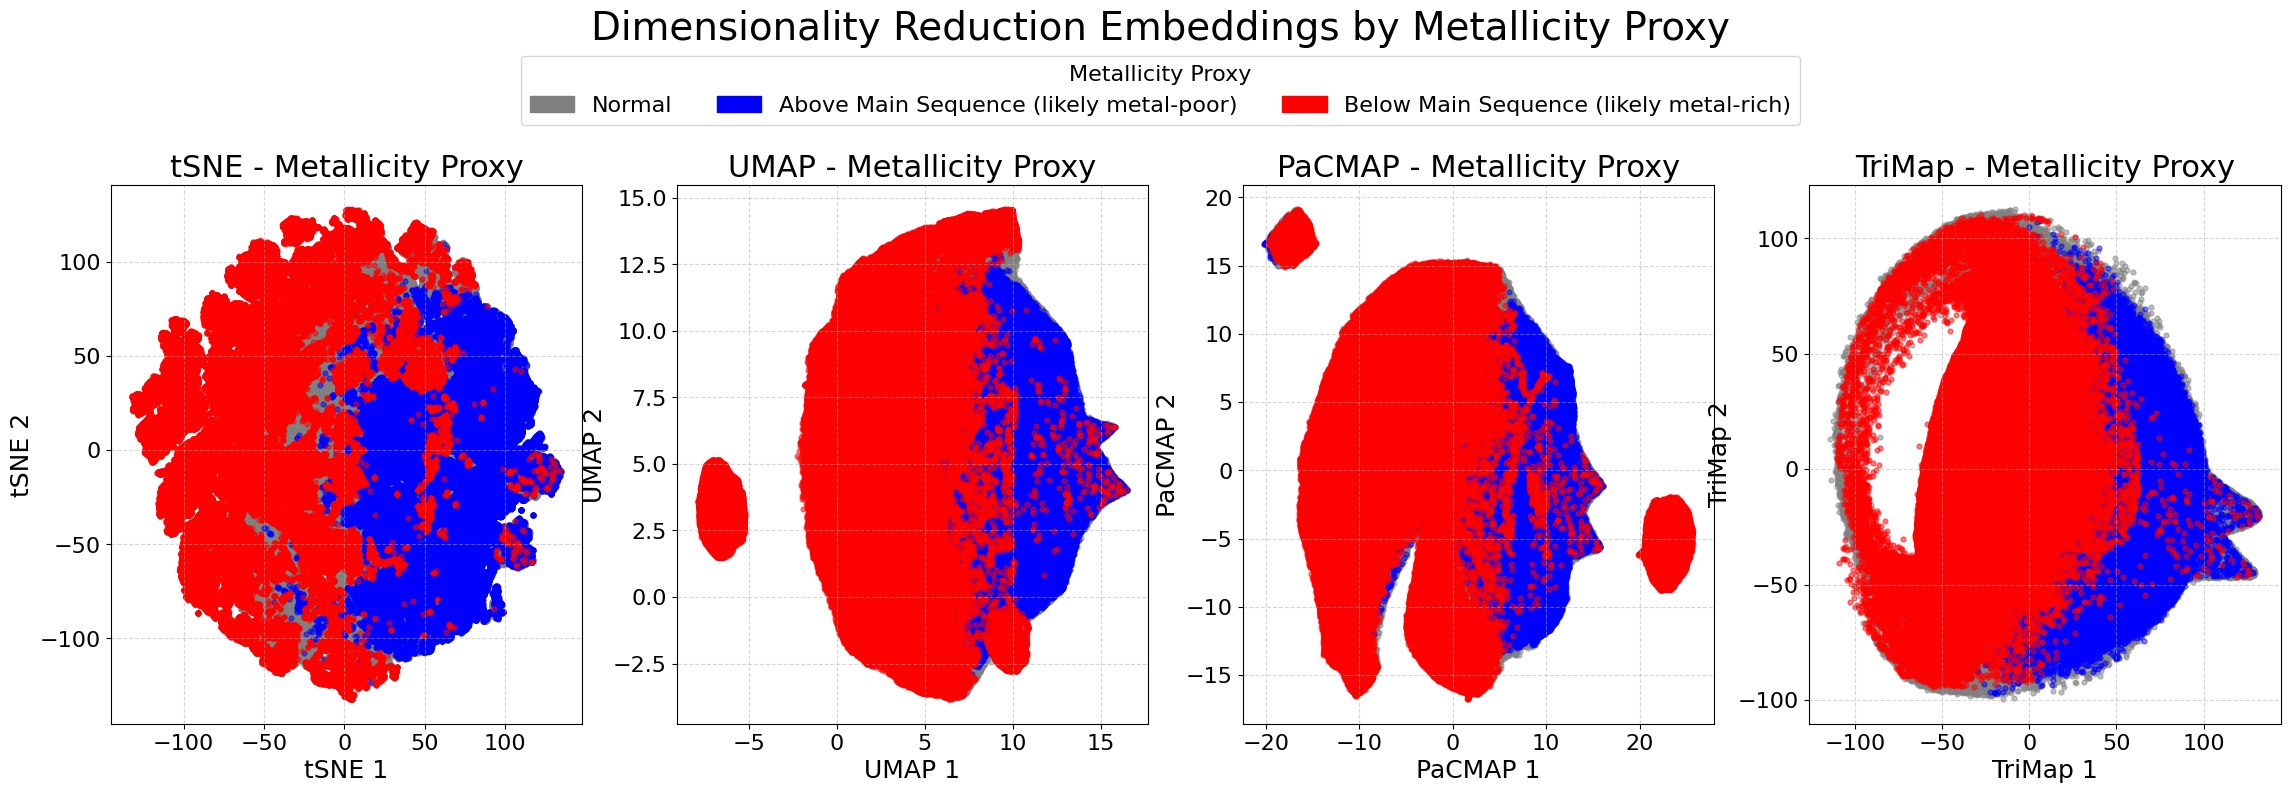

In [ ]:
# Metallicity proxy: BP-RP vs. G magnitude residuals (stars below/above main sequence)
# Filter out NaN and inf values before polyfit
valid_mask = (
    np.isfinite(full_plotting_df['bp_rp_color']) &
    np.isfinite(full_plotting_df['phot_g_mean_mag'])
)

bp_rp_valid = full_plotting_df.loc[valid_mask, 'bp_rp_color']
gmag_valid = full_plotting_df.loc[valid_mask, 'phot_g_mean_mag']

if len(bp_rp_valid) > 10:
    poly_coeffs = np.polyfit(bp_rp_valid, gmag_valid, 2)
    main_seq_fit = np.polyval(poly_coeffs, full_plotting_df['bp_rp_color'])
    metallicity_proxy = full_plotting_df['phot_g_mean_mag'] - main_seq_fit
else:
    metallicity_proxy = np.zeros(len(full_plotting_df))

metallicity_class = np.full(len(full_plotting_df), 'Normal', dtype=object)
metallicity_class[metallicity_proxy < -2] = 'Above Main Sequence (likely metal-poor)'
metallicity_class[metallicity_proxy > 0.5] = 'Below Main Sequence (likely metal-rich)'
metallicity_colors = {'Normal': 'grey', 'Above Main Sequence (likely metal-poor)': 'blue', 'Below Main Sequence (likely metal-rich)': 'red'}

title_fontsize = 22
label_fontsize = 18
legend_fontsize = 16
suptitle_fontsize = 28

# Plot DR embeddings colored by metallicity proxy
fig, axes = plt.subplots(1, n_methods, figsize=(7*n_methods, 7), squeeze=False)

for idx, method_name in enumerate(dr_methods):
    ax = axes[0][idx]
    emb_data = embeddings[method_name]

    for cls, color in metallicity_colors.items():
        mask = (metallicity_class == cls)
        if np.any(mask):
            ax.scatter(emb_data[mask, 0], emb_data[mask, 1], s=12, alpha=0.5, label=cls, color=color)

    ax.set_xlabel(f'{method_name} 1', fontsize=label_fontsize)
    ax.set_ylabel(f'{method_name} 2', fontsize=label_fontsize)
    ax.set_title(f'{method_name} - Metallicity Proxy', fontsize=title_fontsize)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(axis='both', which='major', labelsize=label_fontsize-2)

handles = [mpatches.Patch(color=color, label=cls) for cls, color in metallicity_colors.items()]
fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=3, fontsize=legend_fontsize, title="Metallicity Proxy", title_fontsize=legend_fontsize)

plt.suptitle('Dimensionality Reduction Embeddings by Metallicity Proxy', fontsize=suptitle_fontsize, y=1.13)
plt.tight_layout(rect=[0, 1.5, 1, 1.08])
plt.show()

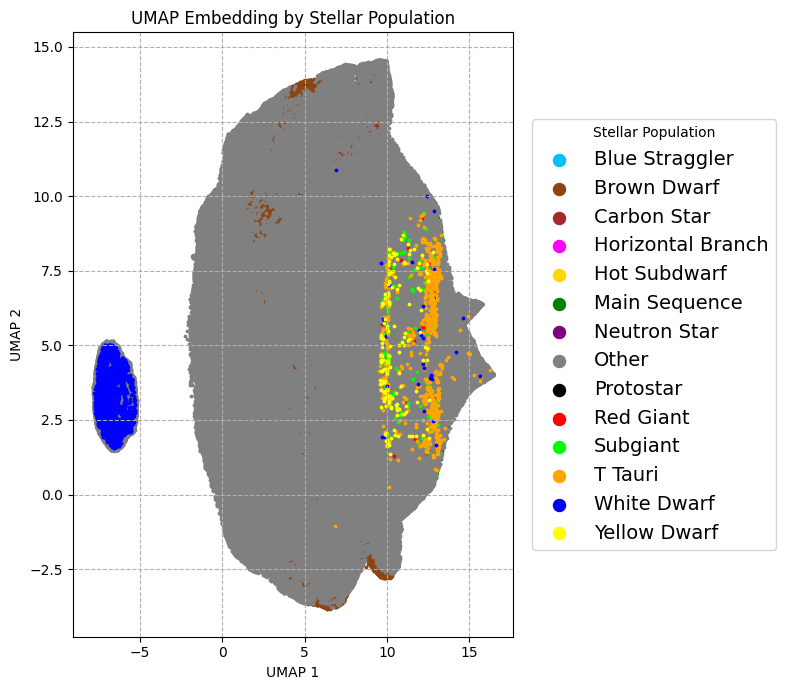

In [ ]:
# Plot UMAP embedding colored by stellar population
method_name = 'UMAP'

if method_name in embeddings and 'population_labels' in locals():
    emb_data = embeddings[method_name]
    fig, ax = plt.subplots(figsize=(8, 7))
    unique_pops = np.unique(population_labels)

    for pop in unique_pops:
        mask = (population_labels == pop)
        if np.any(mask):
            ax.scatter(
                emb_data[mask, 0], emb_data[mask, 1],
                s=3, alpha=1, label=pop, color=colors.get(pop, 'grey')
            )

    ax.set_xlabel(f'{method_name} 1')
    ax.set_ylabel(f'{method_name} 2')
    ax.set_title(f'{method_name} Embedding by Stellar Population')
    ax.grid(True, linestyle='--', alpha=1.0)
    ax.legend(markerscale=5, fontsize=14, title="Stellar Population", loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.tight_layout()
    plt.show()